In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import copy
import math

# 0. Import & clean up the datas 

## 0.1 Import the datas :

In [3]:
data_file = "45.81N-5.77E-TAVG-Trend.txt"

In [4]:
# initialize lists
year = []
month = []
anomaly = []

In [5]:
# import data from txt file
with open(data_file, 'r', encoding = 'latin1') as f:
    reader = csv.reader(f)
    for line in reader:
        lin = line[0].split()
        if len(lin) == 12 and lin[0] != "%": # skip non-data lines
            year.append(float(lin[0]))
            month.append(float(lin[1]))
            anomaly.append(float(lin[2]))

In [6]:
# convert to numpy array
year = np.array(year)
month = np.array(month)
anomaly = np.array(anomaly)

In [7]:
date = year + (month-0.5)/12.0 # convert date to decimal year
print(date)

[1743.20833333 1743.29166667 1743.375      ... 2020.79166667 2020.875
 2020.95833333]


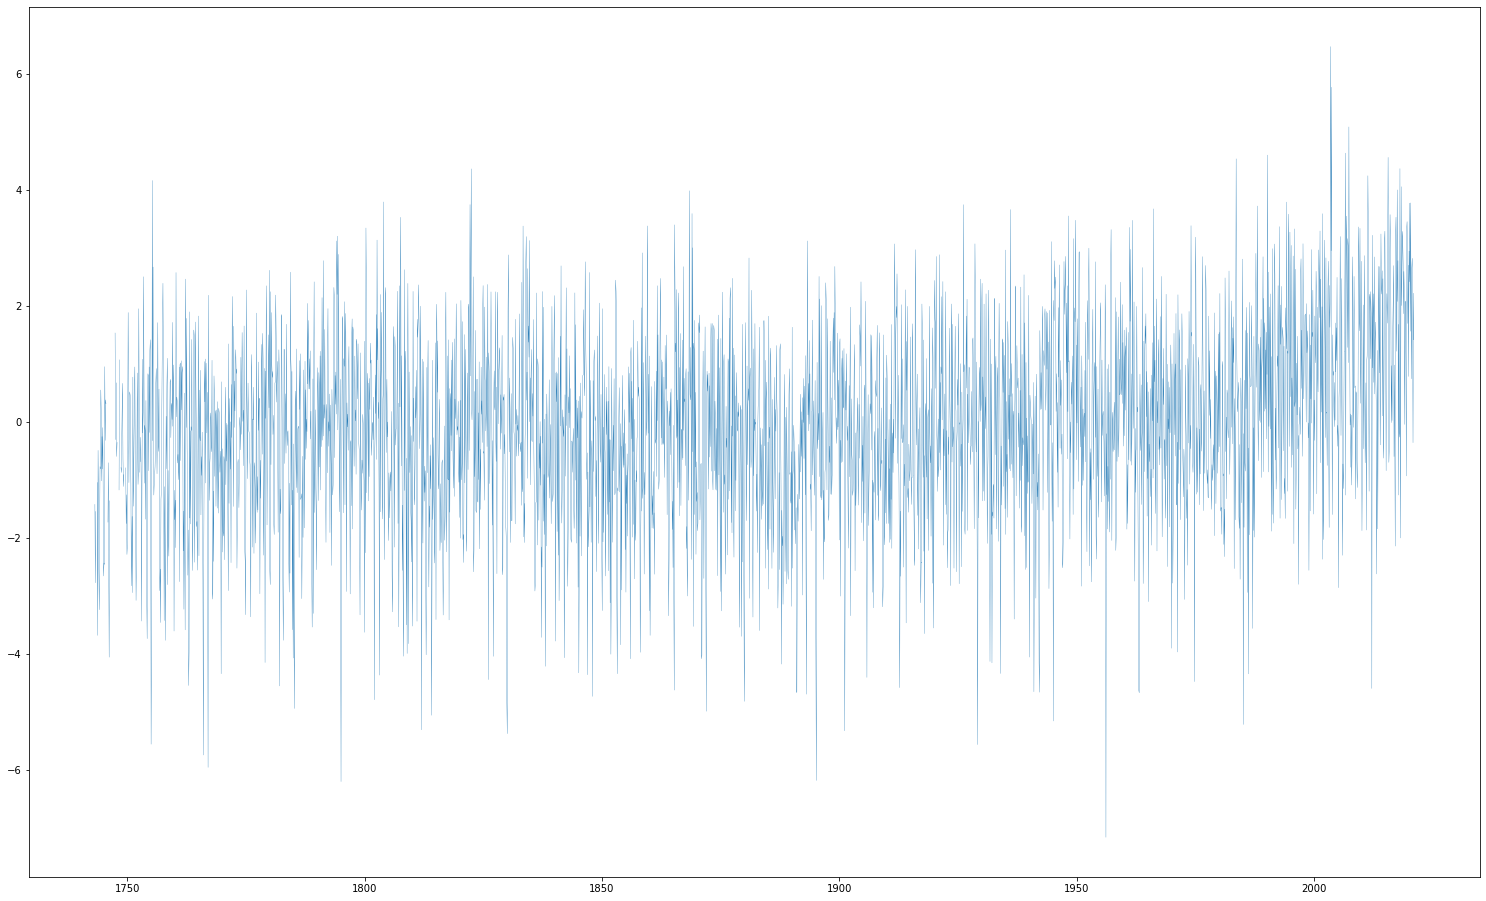

In [8]:
plt.figure(figsize=(26,16))
plt.plot(date,anomaly,linewidth=0.3)
plt.show()

## 0.2 Crop the time series for which most of the temperatures are available :

In [9]:
print (len(anomaly), len(date)) # the initial length of anomaly and date array

3334 3334


In [10]:
np.isnan(anomaly).sum() #total number of missing data in anomaly (NaN)

28

In [11]:
np.concatenate(np.argwhere(np.isnan(anomaly))) #All the indexes in the anomaly that have NaN

array([  3,   5,  29,  31,  32,  38,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  50,  53,  57,  58,  59,  60,  63,  64,  65,  74,  76,
        77, 114])

In [12]:
indexes2remove2 = np.concatenate([np.arange(0, 78), [114]])
indexes2remove2 #A list with all the line indexes we will remove because of the missing datas

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
       114])

In [13]:
anomaly2 = np.delete(anomaly, indexes2remove2) #We remove the missing datas from anomaly 
date2 = np.delete(date, indexes2remove2) #We have to do the same operation the date array 
np.isnan(anomaly2).sum() # We remove all the NaN missing data in our anomaly array

0

In [14]:
print (len(anomaly2), len(date2)) # same length

3255 3255


## 0.3 Interpolation of the datas :

In [15]:
from scipy.interpolate import interp1d

In [16]:
x = np.linspace(1749.7, 2021, len(date2), endpoint=True)
y = copy.deepcopy(anomaly2)
f = interp1d(x, y, kind="cubic")

In [17]:
xnew = np.linspace(1749.7, 2021, num= int(1e+4))
ynew = f(xnew)
len(ynew)

10000

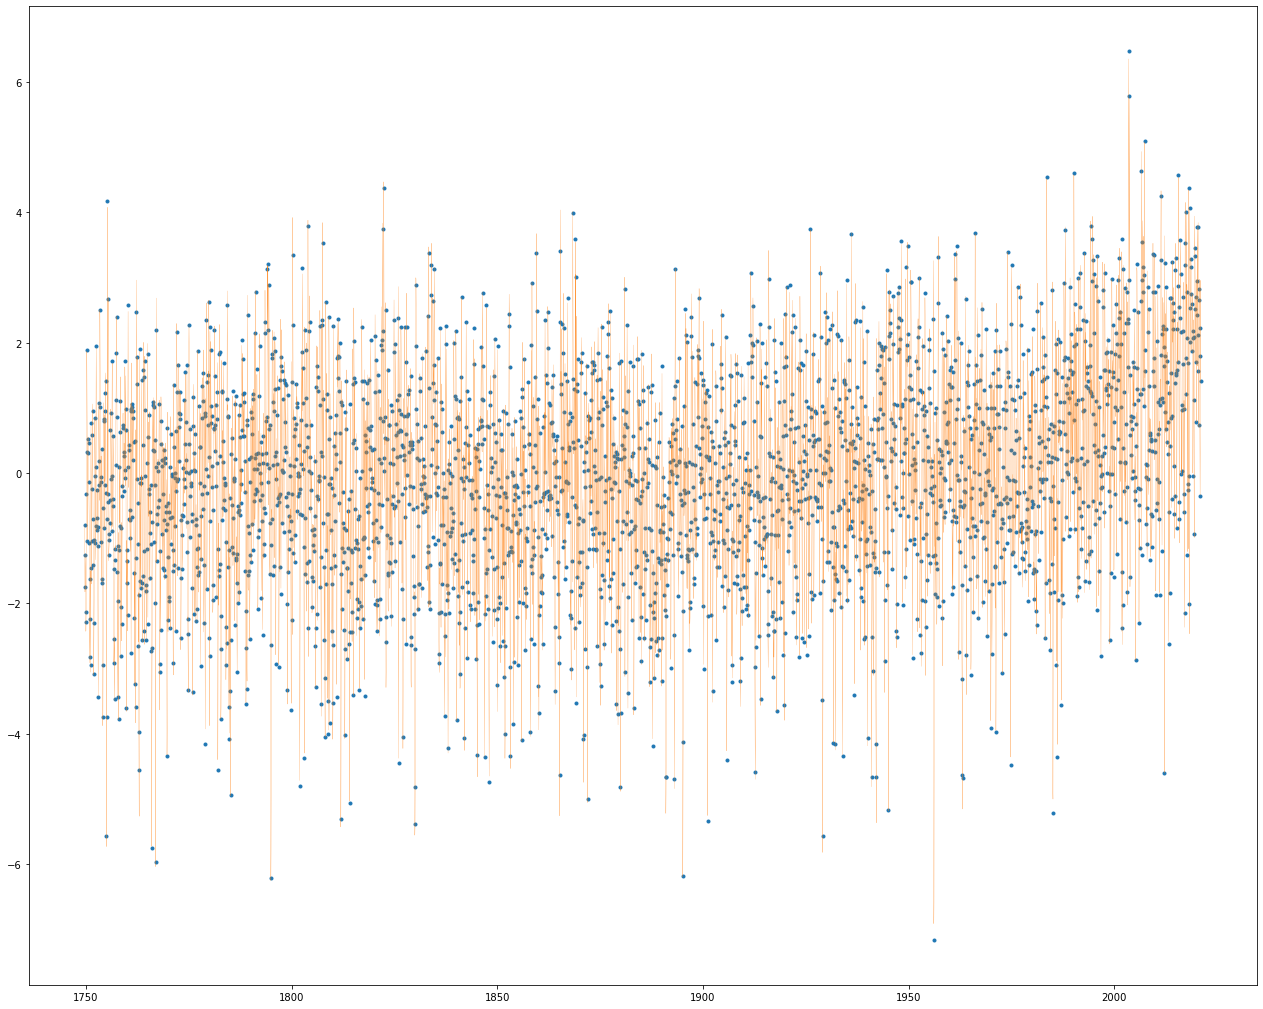

In [18]:
plt.figure(figsize=(22,18))
plt.plot(x, y, '.', xnew, ynew, '-', linewidth = 0.2)
plt.show()

# 1. Trend

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [20]:
X = xnew.reshape(len(xnew), 1)
Y = ynew.reshape(len(ynew), 1)

In [21]:
# 1. Constant regression :

In [22]:
regr0 = [np.mean(ynew) for i in range(len(xnew))]

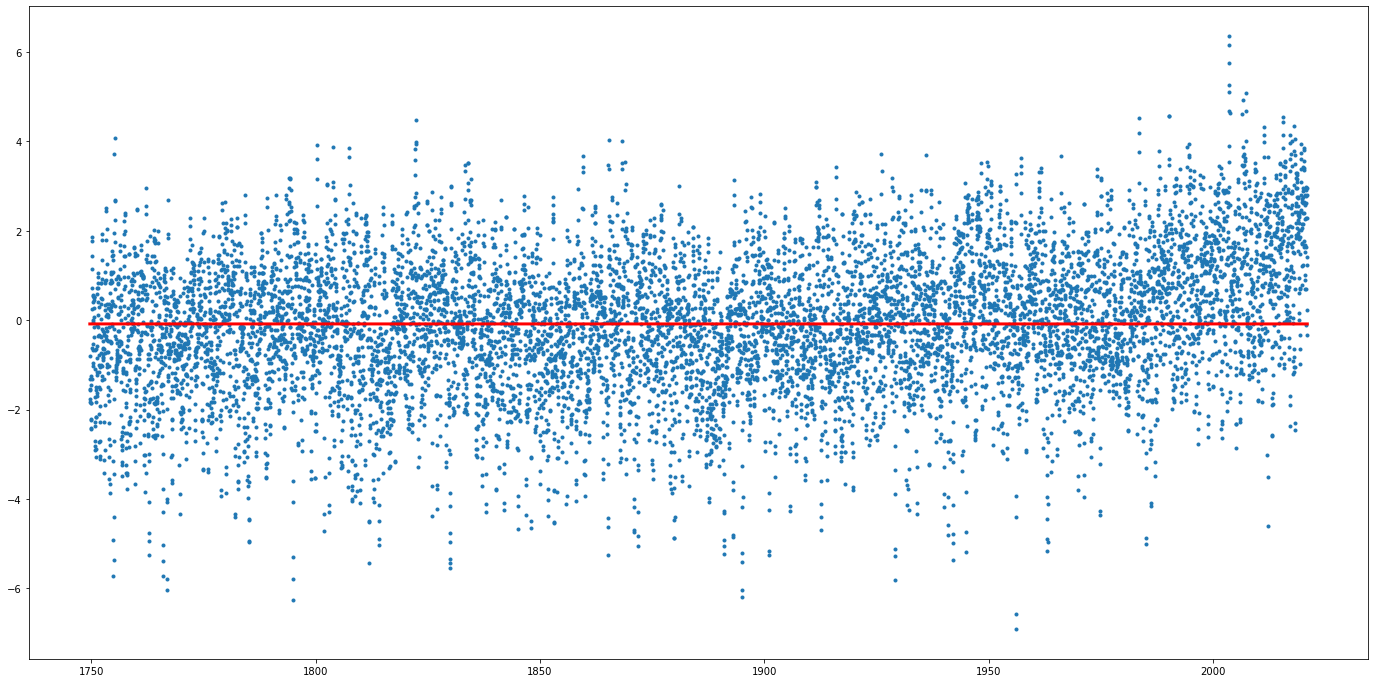

In [23]:
plt.figure(figsize=(24, 12))
plt.scatter(X, Y, marker='.')
plt.plot(X, regr0, color = 'red', linewidth = 3)
plt.show()

In [24]:
r2_score(Y, regr0)

0.0

In [25]:
#2. Linear Regression :

In [26]:
regr1 = LinearRegression()
regr1.fit(X, Y)

LinearRegression()

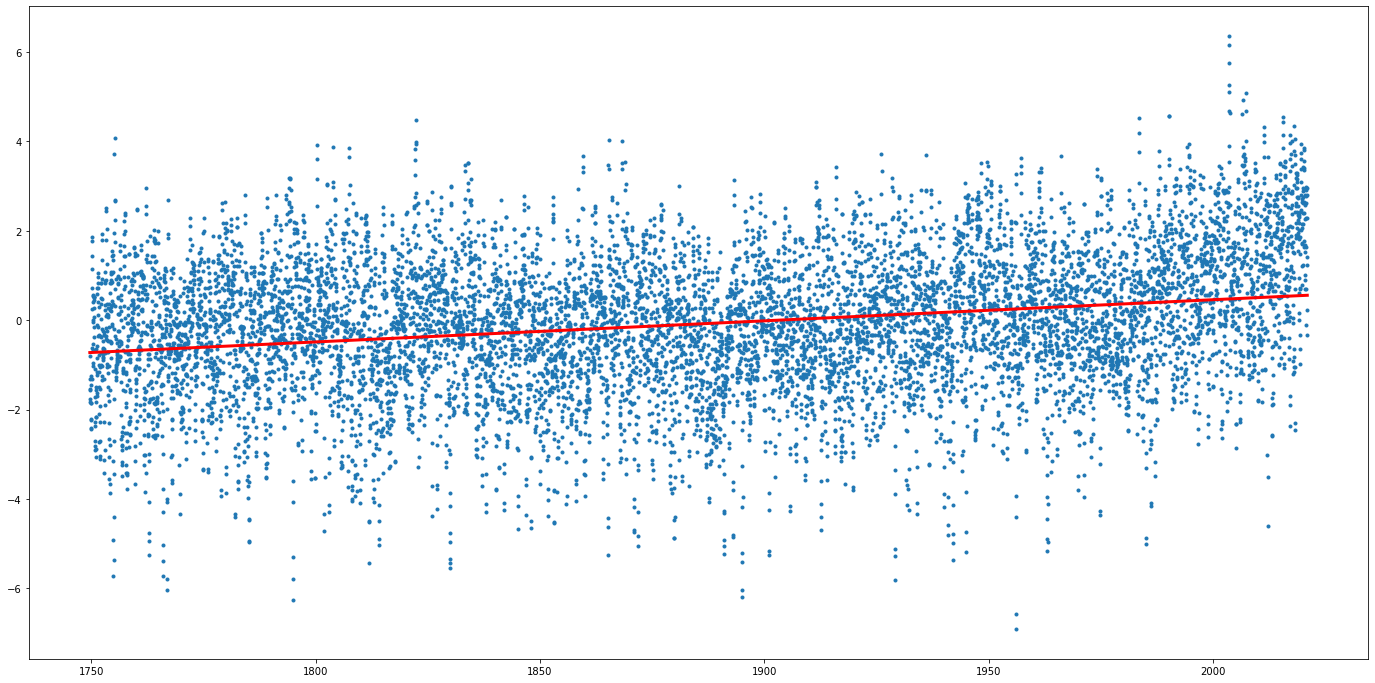

In [27]:
plt.figure(figsize=(24, 12))
plt.scatter(X, Y, marker='.')
plt.plot(X, regr1.predict(X), color = 'red', linewidth = 3)
plt.show()

In [28]:
r2_score(Y, regr1.predict(X))

0.056370594447296196

In [29]:
#3. Quadratic regression :

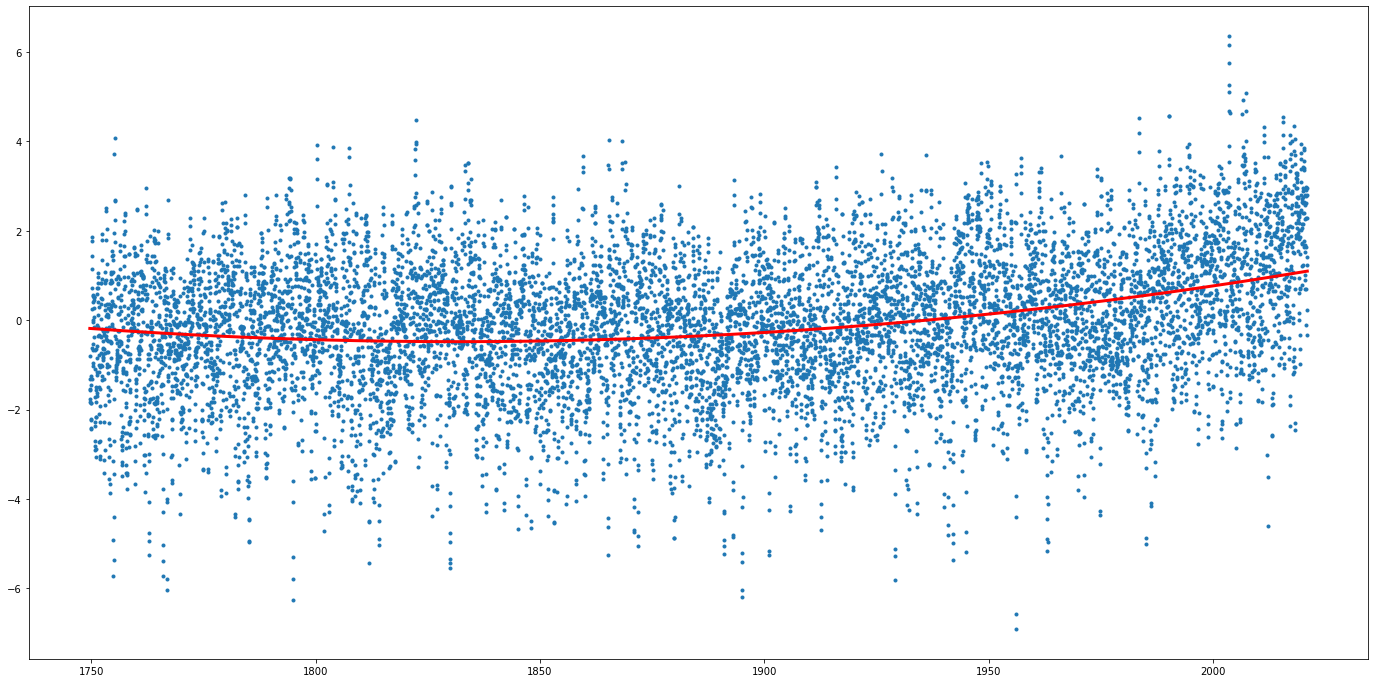

In [30]:
p2 = np.poly1d(np.polyfit(xnew, ynew, 2))
plt.figure(figsize=(24, 12))
plt.scatter(X, Y, marker='.')
plt.plot(xnew, p2(xnew), c='r', linewidth = 3)
plt.show()

In [31]:
print(p2) # Our trinome equation 

           2
4.402e-05 x - 0.1613 x + 147.2


In [32]:
r2_score(ynew, p2(xnew))

0.08038910551427958

In [33]:
#4. Cubic regression :

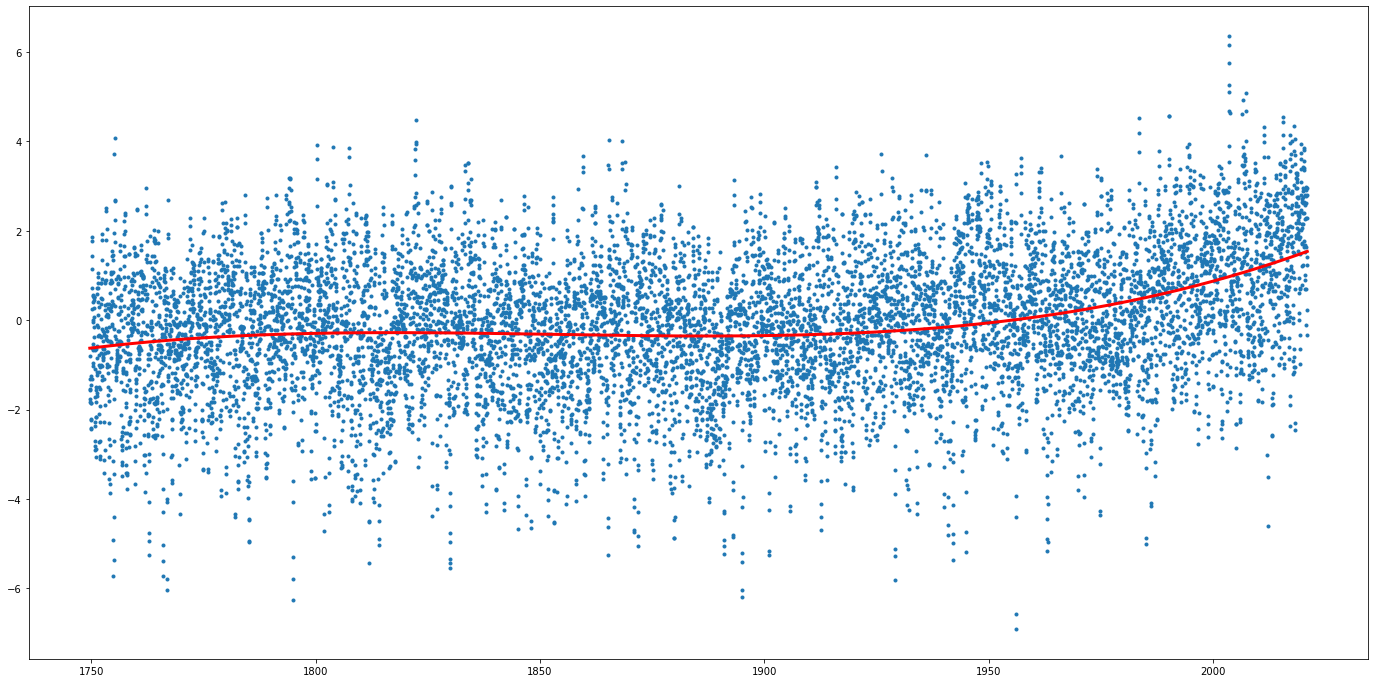

In [34]:
p3 = np.poly1d(np.polyfit(xnew, ynew, 3))
plt.figure(figsize=(24, 12))
plt.scatter(X, Y, marker='.')
plt.plot(xnew, p3(xnew), c='r', linewidth = 3)
plt.show()

In [35]:
r2_score(ynew, p3(xnew))

0.09187313757616622

In [36]:
def SSE (Y, Y_pred):
    sse = 0
    for i in range(len(Y)):
        sse += (Y[i] - Y_pred[i])**2
    return (sse)

In [37]:
sse0 = SSE(ynew, regr0)
sse1 = SSE(ynew, regr1.predict(X))
sse2 = SSE(ynew, p2(xnew))
sse3 = SSE(ynew, p3(xnew))
print(sse0, sse1, sse2, sse3)

24293.155016091703 [22923.73542683] 22340.250014228237 22061.266643139094


It's like a limited developpment : higher is the degree, better is the fitting of our model.

Then we have chosen to keep the cubic regression. But if we want to be more rigorous we have to make statistical test(s) to compare the differents models in order to see a significant difference between them.  

## 2. De-trended data

In [38]:
y_detrended = ynew-p3(xnew)
print(np.mean(y_detrended)) # Very close to 0, That's what we wanted.

2.7379357447898655e-12


## 3. Power Spectral Density

In [39]:
def psd(x,dt):
    H = np.fft.fft(x)
    N = len(x)
    S = H*np.conjugate(H)/N
    f = 1/dt * np.arange(0,N)/N
    return f, S

In [40]:
f, S = psd(ynew, 0.25)

In [41]:
N = len(y_detrended)
N2 = int(N/2)+1
n  = range(N2) # this goes from 0 to N/2 if even, and from 0 to (N-1)/2 if odd

/home/nicolas/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


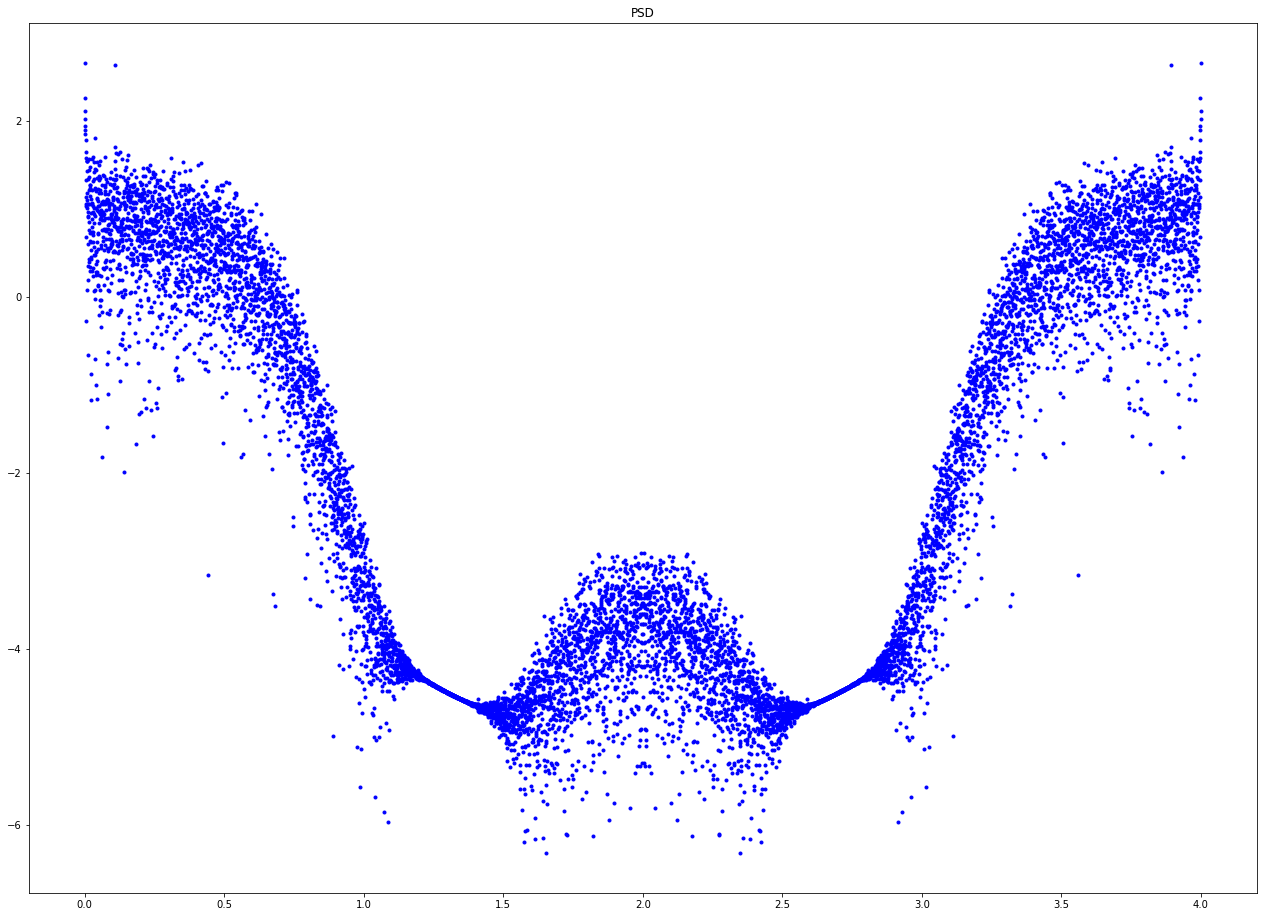

In [60]:
plt.figure(figsize=(22, 16))
plt.plot(f,np.log10(S),'bo', marker = '.', linewidth = 0.5) # uncoment to plot the whole PSD
plt.title("PSD")
plt.show()

## 4. Auto-correlation

In [51]:
def autocorrel(S):
    return np.fft.ifft(S)

In [55]:
K = autocorrel(S)

In [56]:
print(K)

[2.43631955+0.00000000e+00j 2.1919664 +1.26695529e-18j
 1.58640698-4.37427872e-18j ... 0.91218275+3.28052646e-18j
 1.58640698+6.16051082e-17j 2.1919664 -3.32285680e-17j]


/home/nicolas/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


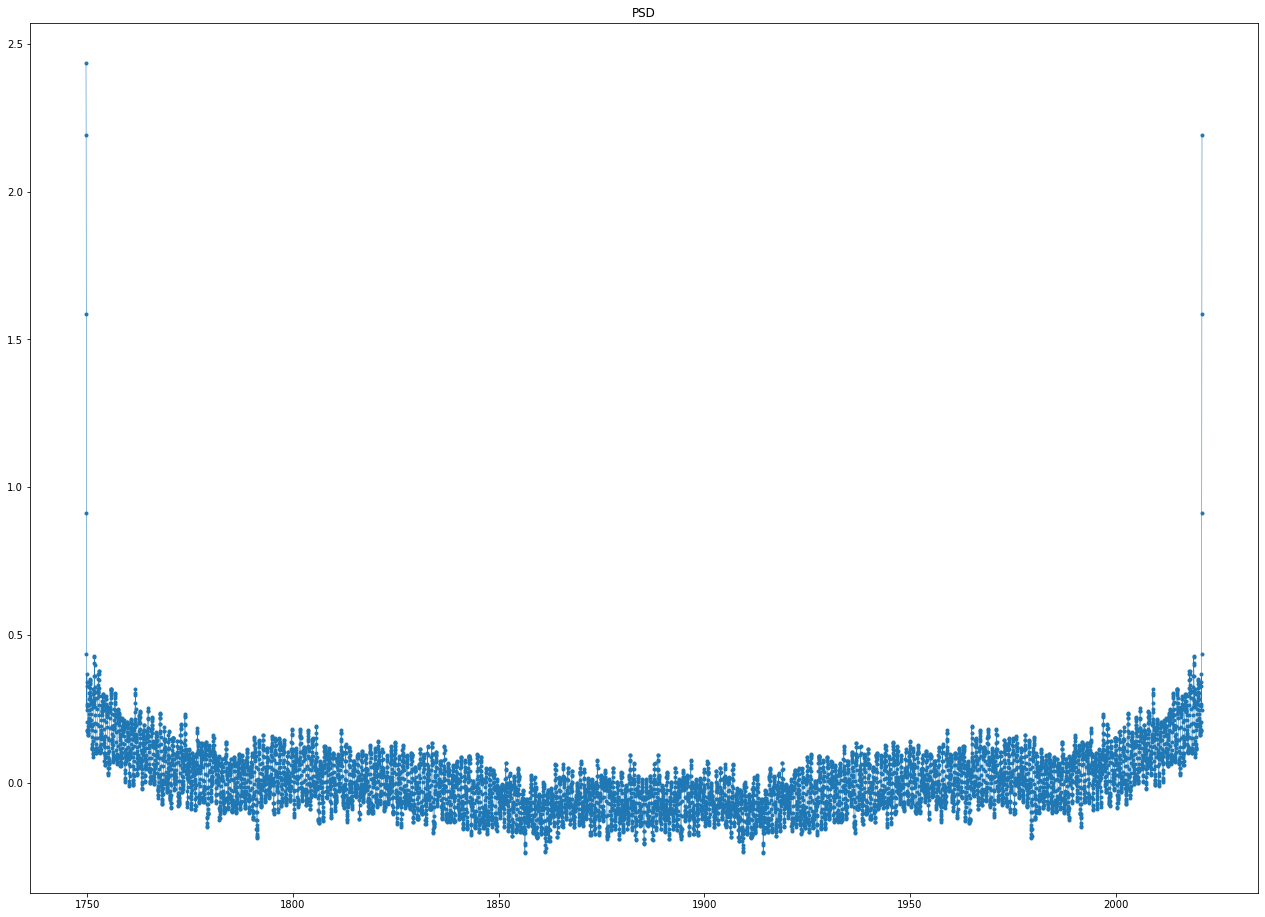

In [58]:
plt.figure(figsize=(22, 16))
plt.plot(xnew, K, marker = '.', linewidth = 0.5) # uncoment to plot the whole PSD
plt.title("PSD")
plt.show()

 ## 5. Modelling

In [67]:
def solve_OU(theta,mu,sigma,tfinal,x0,dt): # Ornstein-Uhlenbeck
    sqrt_dt = np.sqrt(dt)
    n = int(1 + tfinal/dt)
    x = np.zeros(n)
    t = np.zeros(n)
    x[0] = x0
    for i in range(n-1):
        x[i+1] = x[i] + dt*( theta*(x[i] - mu) ) + sqrt_dt*sigma*(x[i])*np.random.randn()
        t[i+1] = t[i] + dt
    return x, t

In [66]:
solve_OU(theta=1.1, mu=0.3, sigma=0.8, tfinal=2, x0=0, dt=0.25)

TypeError: 'float' object is not callable